In [35]:
import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
# Function to simulate the price of the express certificate at time t using Monte Carlo path

def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = nominal + total_coupon if S_end >= barrier else nominal * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

In [37]:
###============= Compute Deltas===================

def compute_daily_delta(S_t, r, sigma, T, S0, h=0.5, n_paths=10000):
    np.random.seed(42)
    V_plus = price_certificate(S_t + h, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_minus = price_certificate(S_t - h, r, sigma, T, S0, n_paths)
    return (V_plus - V_minus) / (2 * h)

In [38]:
###==============Download and prepare Data==================
df_prices, _ = module.download_stock_price_data(['SIE.DE'], '2024-05-17', '2025-05-17')

# Prepare stock dataframe
df_stock = df_prices.rename(columns={"SIE.DE": "Close"}).reset_index()
df_stock["Date"] = pd.to_datetime(df_stock["Date"])
df_stock = df_stock.sort_values("Date").reset_index(drop=True)

# --- Parameters ---
S0=187.98
r = 0.022752  # use your 6-year spot rate as a decimal
sigma = 0.27772
T_total = 6
N_total = 252 * T_total
dt = T_total / N_total
n_paths = 10000

nominal = 982.92
coupon = 70
total_coupon = 6 * coupon
early_redemption_levels = [1.00, 0.95, 0.90, 0.85, 0.80]
observation_days = [252 * i for i in range(1, 6)]
barrier = 0.6 * S0  # fixed based on S0

# --- Simulate each day using actual S_t ---
simulated_prices = []
daily_deltas = []
for idx, row in df_stock.iterrows():
    S_t = float(row["Close"])  # actual stock price on that day
    remaining_days = N_total - idx
    remaining_T = remaining_days / 252

    
    # Simulate paths
    Z = np.random.standard_normal((n_paths, remaining_days))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t

    for t in range(1, remaining_days):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    # Compute payoffs
    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate(observation_days):
            if obs_day < len(path) and path[obs_day] >= early_redemption_levels[j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (nominal + (j + 1) * coupon))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            if S_end >= barrier:
                val = nominal + total_coupon
            else:
                val = nominal * (S_end / S0)
            payoffs.append(np.exp(-r * remaining_T) * val)

    #compute dletas
    delta = compute_daily_delta (S_t, r, sigma, remaining_T, S0)
    daily_deltas.append(delta)

    
    simulated_prices.append(np.mean(payoffs))


[*********************100%***********************]  1 of 1 completed


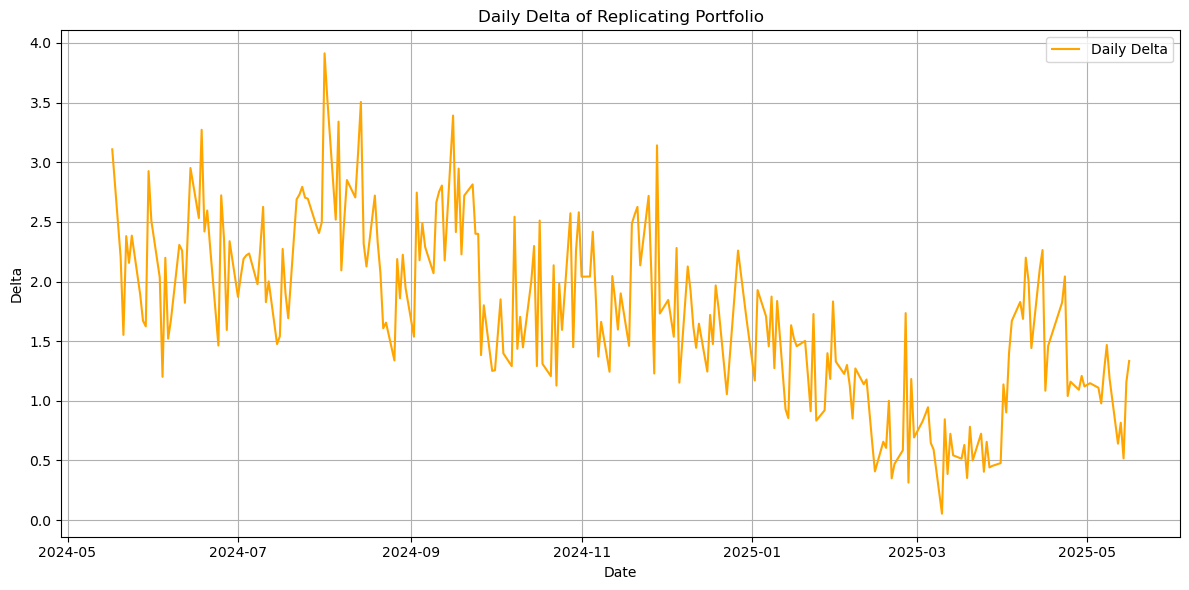

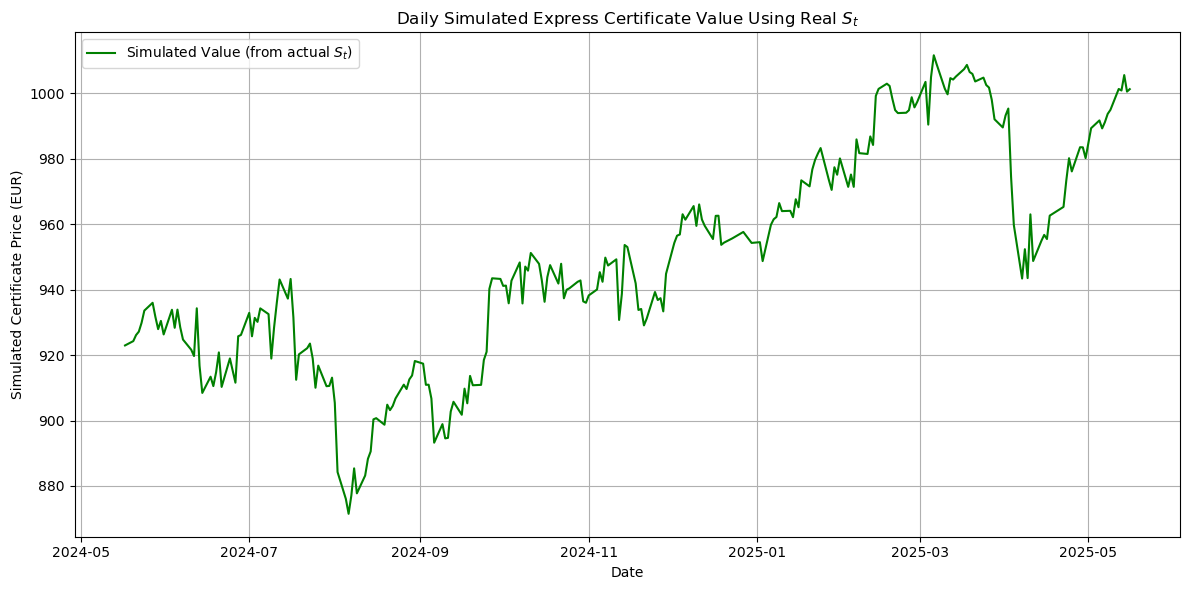

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(df_stock["Date"], daily_deltas, label="Daily Delta", color="orange")
plt.title("Daily Delta of Replicating Portfolio")
plt.xlabel("Date")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df_stock["Date"], simulated_prices, label="Simulated Value (from actual $S_t$)", color="green")
plt.title("Daily Simulated Express Certificate Value Using Real $S_t$")
plt.xlabel("Date")
plt.ylabel("Simulated Certificate Price (EUR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

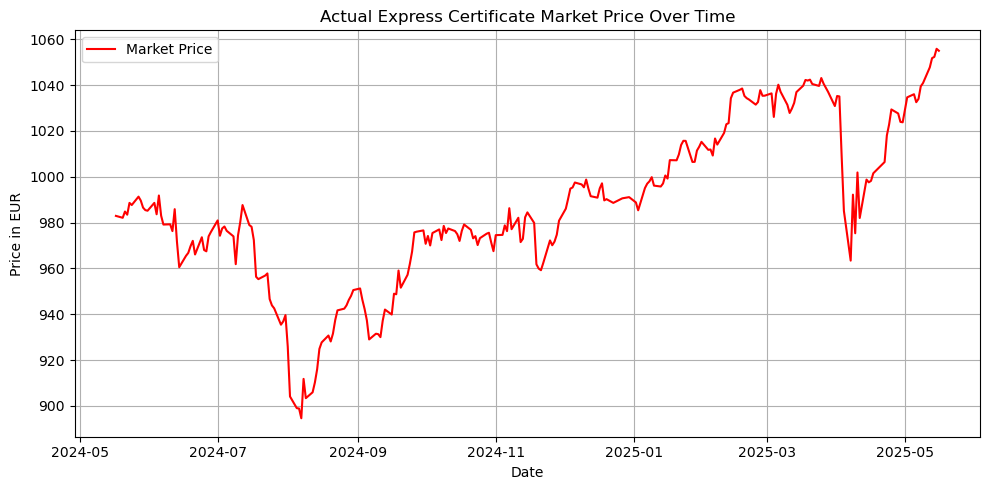

In [40]:
###================Plot the real certificate price data================
# Load CSV
df = pd.read_csv("certificate_price_data.csv", sep=";")

# Clean numeric columns: remove thousands separator and fix decimal
df["Schluss"] = df["Schluss"].str.replace(".", "", regex=False)  # remove thousand dots
df["Schluss"] = df["Schluss"].str.replace(",", ".", regex=False)  # change decimal comma to dot
df["Schluss"] = df["Schluss"].astype(float)

# Parse and sort dates
df["Datum"] = pd.to_datetime(df["Datum"], format="%d.%m.%Y")
df = df.sort_values("Datum")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Datum"], df["Schluss"], label="Market Price", color="red")
plt.title("Actual Express Certificate Market Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price in EUR")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
###============Initialize replicating portfolio========
initial_value = 982.97  # Initial certificate price (used as starting portfolio value)
replicating_values_1 = [initial_value]  # List to store portfolio value over time

# Initial cash position: portfolio value minus initial equity investment
cash_position_1 = initial_value - daily_deltas[0] * df_stock["Close"][0]

# --- Rebalance portfolio over time ---
for t in range(1, len(df_stock)):
    # Update cash position with accrued interest
    cash_position_1 *= np.exp(r * dt)

    # Adjust cash for rebalancing: buy/sell stock to reflect delta change
    d_delta = daily_deltas[t] - daily_deltas[t - 1]
    cash_position_1 -= d_delta * df_stock["Close"][t - 1]

    # Compute new portfolio value: equity + cash
    new_value_1 = daily_deltas[t] * df_stock["Close"][t] + cash_position_1
    replicating_values_1.append(new_value_1)

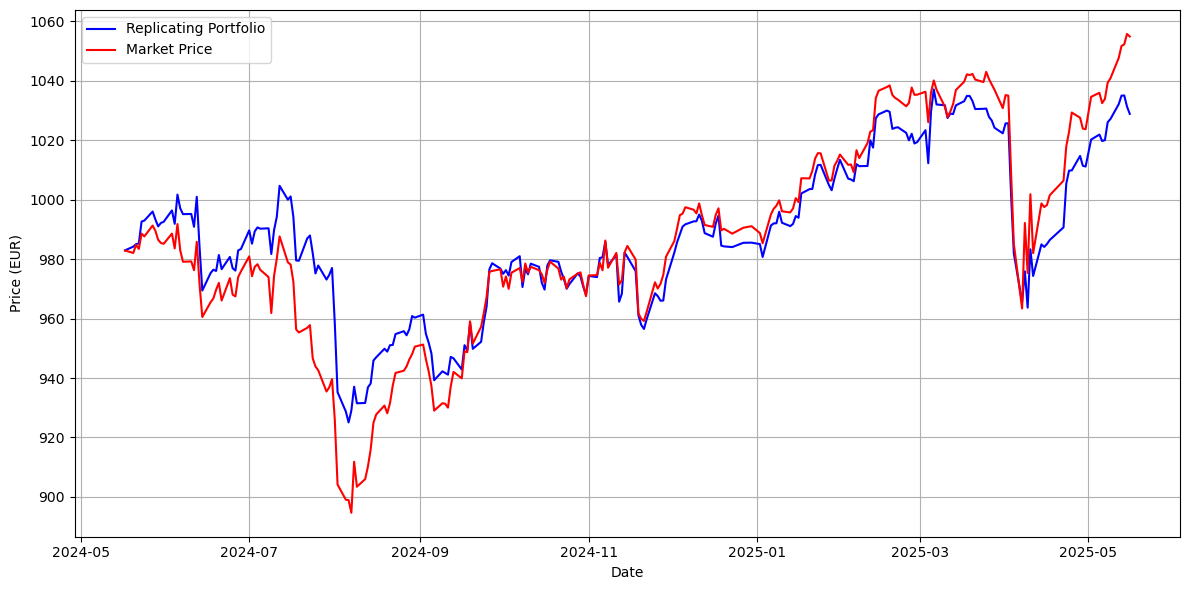

In [42]:
###===============Plot replicated and real prices=================
# --- Plot ---
plt.figure(figsize=(12, 6))

# Plot replicating portfolio
plt.plot(df_stock["Date"], replicating_values_1, label="Replicating Portfolio", color="blue")

plt.plot(df["Datum"], df["Schluss"], label="Market Price", color="red")

#plt.title("Replicating Portfolio vs Market Prices")
plt.xlabel("Date")
plt.ylabel("Price (EUR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("replicating_vs_market.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [43]:

# --- Parameters ---
S0 = 187.98
r = 0.022752
sigma = 0.27772
n_paths = 10000
finite_diff = 0.5
T_snapshot = 1  # 1 year before maturity

# --- Certificate Pricing Function (from your project setup) ---
def price_certificate(S_t, r, sigma, T, S0, n_paths=10000):
    N = int(252 * T)
    dt = T / N
    Z = np.random.standard_normal((n_paths, N))
    paths = np.zeros_like(Z)
    paths[:, 0] = S_t
    for t in range(1, N):
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z[:, t - 1])

    payoffs = []
    for i in range(n_paths):
        path = paths[i]
        redeemed = False
        for j, obs_day in enumerate([252 * i for i in range(1, 6)]):
            if obs_day < len(path) and path[obs_day] >= [1.00, 0.95, 0.90, 0.85, 0.80][j] * S0:
                payoffs.append(np.exp(-r * (obs_day / 252)) * (1000 + (j + 1) * 70))
                redeemed = True
                break
        if not redeemed:
            S_end = path[-1]
            val = 1000 + 6 * 70 if S_end >= 0.6 * S0 else 1000 * (S_end / S0)
            payoffs.append(np.exp(-r * T) * val)
    return np.mean(payoffs)

# --- Delta Function ---
def compute_delta(S, r, sigma, T, S0, h=0.5):
    np.random.seed(42)
    V_plus = price_certificate(S + h, r, sigma, T, S0, n_paths)
    np.random.seed(42)
    V_minus = price_certificate(S - h, r, sigma, T, S0, n_paths)
    return (V_plus - V_minus) / (2 * h)



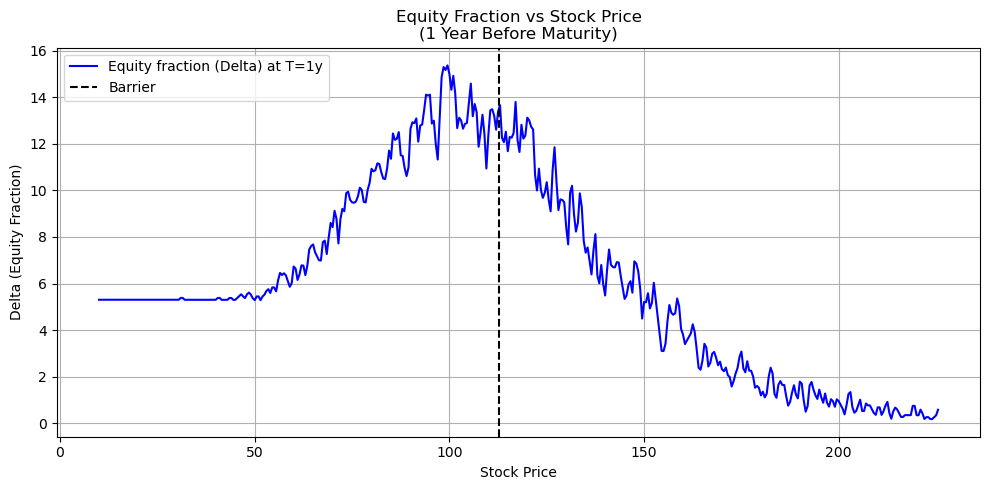

In [44]:
# --- Compute equity fractions (deltas) ---
price_range = np.arange(10, 226, 0.5)
deltas_T1 = [compute_delta(S, r, sigma, T_snapshot, S0, finite_diff) for S in price_range]

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(price_range, deltas_T1, color='blue', label="Equity fraction (Delta) at T=1y")

plt.axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
plt.title("Equity Fraction vs Stock Price\n(1 Year Before Maturity)")
plt.xlabel("Stock Price")
plt.ylabel("Delta (Equity Fraction)")
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig("equity.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

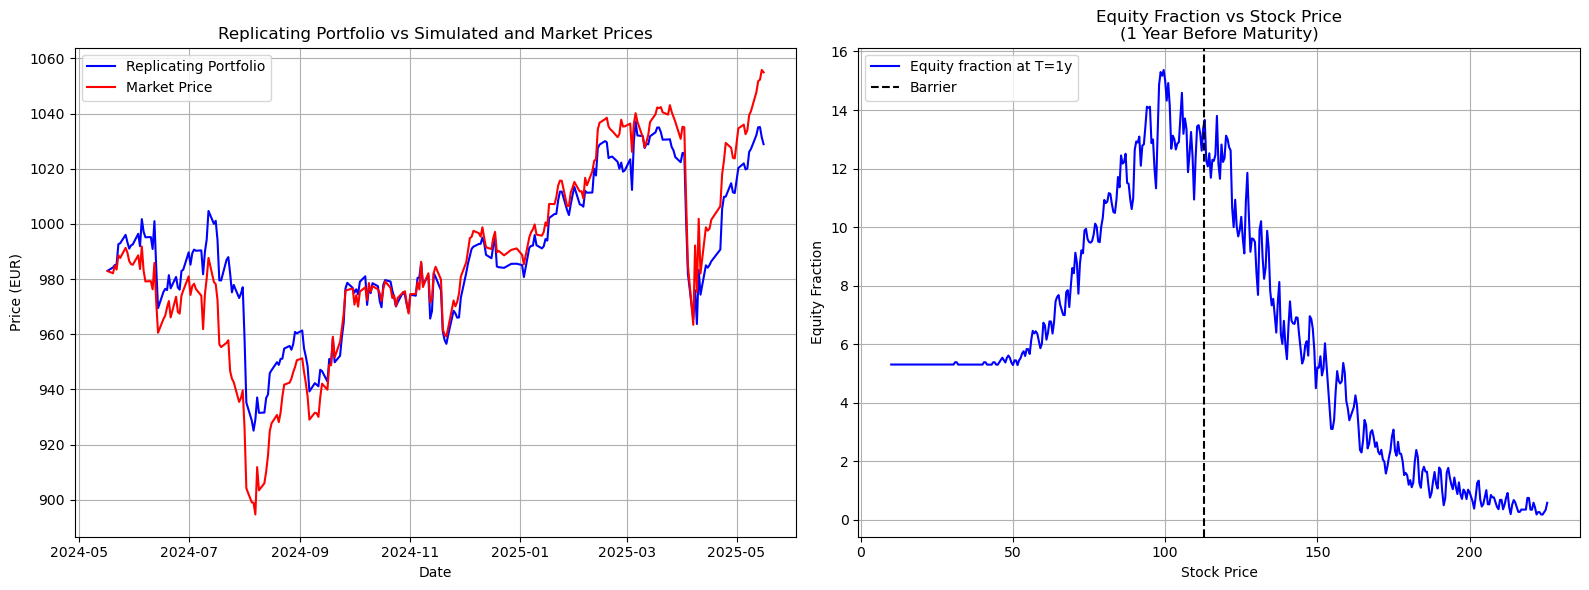

In [45]:
import matplotlib.pyplot as plt

# --- Side-by-side Plots ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# --- Left Plot: Replicating Portfolio vs Market ---
axs[0].plot(df_stock["Date"], replicating_values_1, label="Replicating Portfolio", color="blue")
axs[0].plot(df["Datum"], df["Schluss"], label="Market Price", color="red")
axs[0].set_title("Replicating Portfolio vs Simulated and Market Prices")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price (EUR)")
axs[0].legend()
axs[0].grid(True)

# --- Right Plot: Equity Fraction ---
axs[1].plot(price_range, deltas_T1, color='blue', label="Equity fraction at T=1y")
axs[1].axvline(0.6 * S0, linestyle='--', color='black', label="Barrier")
axs[1].set_title("Equity Fraction vs Stock Price\n(1 Year Before Maturity)")
axs[1].set_xlabel("Stock Price")
axs[1].set_ylabel("Equity Fraction")
axs[1].legend(loc='upper left')
axs[1].grid(True)

# --- Final Layout ---
plt.tight_layout()
#plt.savefig("replication_and_equity_side_by_side.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()